# Text to Image (Stable Diffusion)

![alt text](image-assets/StabilityAi_Logo-Coloured_On_Black-12.png "stability.ai")

---
Welcome to Amazon [SageMaker Built-In Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Sagemaker Built-In Algorithms to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).

In this demo notebook, we demonstrate how to use SageMaker Python SDK for Text-to-Image. Text-to-Image is the task of generating realistic image given any text input. Here, we show how to use state-of-the-art pre-trained Stable Diffusion models for generating image from text.

---

1. [Set Up](#1.-Set-Up)
2. [Select a model](#2.-Select-a-model)
3. [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
4. [Query endpoint and parse response](#4.-Query-endpoint-and-parse-response)
5. [Advanced features](#5.-Advanced-features)
6. [Clean up the endpoint](#6.-Clean-up-the-endpoint)

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Please see steps in [Onboard to Amazon SageMaker Domain Using Quick setup](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html) to make use of SageMaker Studio.

### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [3]:
!pip install sagemaker --upgrade --quiet


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


#### Permissions and environment variables

---
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### 3. Retrieve Artifacts & Deploy an Endpoint

***

Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.

***

In [5]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base

# model_version="*" fetches the latest version of the model
model_id, model_version = "model-txt2img-stabilityai-stable-diffusion-v2", "*"

endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the pre-trained model and parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE":'20000000',
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env = env,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

-----------!

### 4. Query endpoint and parse response

---
Input to the endpoint is any string of text dumped in json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

---

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = json.dumps(text).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

---
Below, we put in some example input text. You can put in any text and the model predicts the image corresponding to that text.

---

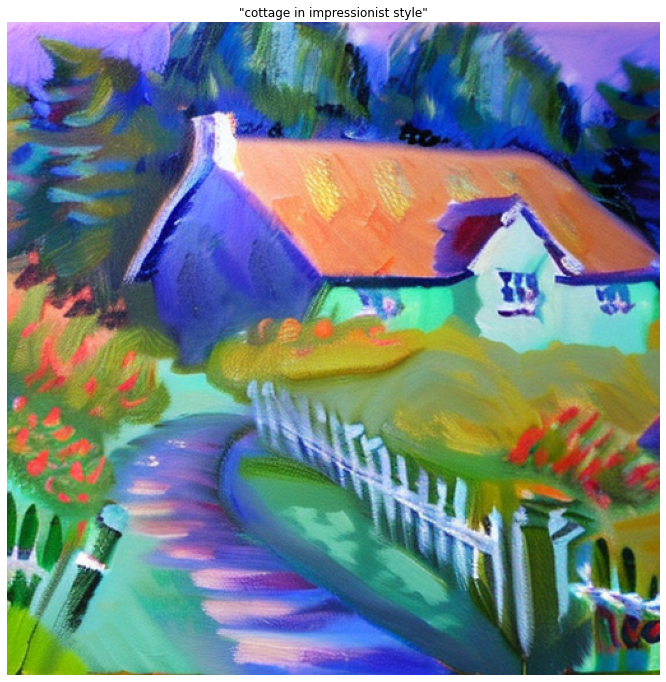

In [7]:
text = "cottage in impressionist style"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 5. Advanced features

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. 
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.
***

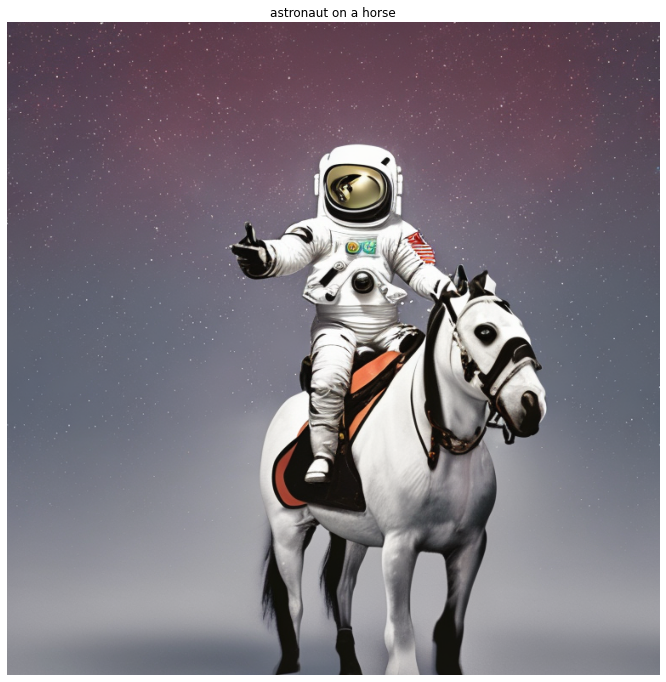

In [8]:
import json

# Stable Diffusion 2.0 was trained on images with dimension 768x768 and achieves best performance when the generated image size is 768x768.  If you used instance type ml.g5.16xlarge for deployment, you may replace width and height larger than 768.
payload = {
    "prompt": "astronaut on a horse",
    "width": 768,
    "height": 768,
    "num_images_per_prompt": 1,
    "num_inference_steps": 50,
    "guidance_scale": 7.5,
}


def query_endpoint_with_json_payload(model_predictor, payload):
    """Query the model predictor with json payload."""

    encoded_payload = json.dumps(payload).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_payload,
        {
            "ContentType": "application/json",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response_multiple_images(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"], response_dict["prompt"]


query_response = query_endpoint_with_json_payload(model_predictor, payload)
generated_images, prompt = parse_response_multiple_images(query_response)

for img in generated_images:
    display_img_and_prompt(img, prompt)

### 6. Clean up the endpoint

In [9]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()